<center>Tópicos selectos de análisis de datos<center>
<center>Tarea 7<center>
<center>Para entregar el 29 de noviembre de 2021<center>

1. En el notebook `MT_attention.ipynb` se encuentra la implementación de un modelo de traducción automática NMT (Neural Machine Translation) basado en una arquitectura sequence to sequence con atención. El modelo que se implementa está basado en LSTM bidireccional para el encoder y LSTM simple para el decoder, y se muestra en la siguiente figura:

In [ ]:
from IPython.display import Image
Image(retina=True, filename='model_nmt.png')

a) Basándote en ése modelo, obtén un modelo NMT para inglés-español y español-inglés. El corpus paralelo se obtuvo de ManyThings.org: http://www.manythings.org/anki/. Si deseas, puedes modificar el modelo, usando por ejemplo GRU en vez de LSTM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

In [ ]:
data_path =  '/content/drive/MyDrive/Tarea7-CDII/spa.txt'
df = pd.read_csv(data_path,encoding='utf-8', sep='	',  names=['English', 'Spanish', 'Attribution'])
# drop attribution
df.drop(['Attribution'], axis=1, inplace=True)
# remove multiple spaces
df.English = df.English.apply(lambda x: " ".join(x.split()))
df.Spanish = df.Spanish.apply(lambda x: " ".join(x.split()))
# lowercase
df.English = df.English.apply(lambda x: x.lower())
df.Spanish = df.Spanish.apply(lambda x: x.lower())
# remove punctuations
#translator= str.maketrans('','', string.punctuation)
#df.English= df.English.apply(lambda x: x.translate(translator))
#df.Spanish= df.Spanish.apply(lambda x: x.translate(translator))
# remove digits
df.English= df.English.apply(lambda x: re.sub(r'[\d]+','', x))
df.Spanish= df.Spanish.apply(lambda x: re.sub(r'[\d]+','', x))

# Add start and end tokens to sentences
df['Spanish'] =df.Spanish.apply(lambda x: '<start> '+ x + ' <end>')
df['English'] =df.English.apply(lambda x: '<start> '+ x + ' <end>')

In [ ]:
df.sample(10)

,English,Spanish
98201,<start> it wasn't as expensive as i expected. ...,<start> no fue tan caro como esperaba. <end>
20842,<start> the bread is fresh. <end>,<start> el pan está fresco. <end>
130906,"<start> this problem is too simple, so it is h...","<start> este problema es demasiado sencillo, p..."
19425,<start> i have one brother. <end>,<start> tengo un hermano. <end>
42122,<start> i met her along the way. <end>,<start> me encontré con ella en el camino. <end>
97182,<start> he devoted his whole life to science. ...,<start> consagró toda su vida a la ciencia. <end>
117284,<start> tom is very likely to know what we sho...,<start> lo más probable es que tom sepa lo que...
77197,<start> tom's enthusiasm is infectious. <end>,<start> el entusiasmo de tom es contagioso. <end>
57258,<start> my aunt brought me flowers. <end>,<start> mi tía me trajo flores. <end>
85260,<start> tom asked me for my phone number. <end>,<start> tom me pidió mi número de teléfono. <end>


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# convert to list for tokenizer
source_texts = df.English.to_list()
target_texts = df.Spanish.to_list()

def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer(filters = '')
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)

# Tokenize source and target sentences
source_tokenizer, source_encoded= tokenize_sent(text= source_texts)
target_tokenizer, target_encoded= tokenize_sent(text= target_texts)

# diccionarios para el mapeo entre one-hot encodings y vocabulario
source_index_word = source_tokenizer.index_word
source_word_index= source_tokenizer.word_index
source_VOCAB_SIZE = len(source_tokenizer.word_counts)+1
target_index_word = target_tokenizer.index_word
target_word_index= target_tokenizer.word_index
target_VOCAB_SIZE=len(target_tokenizer.word_counts)+1

max_source_len = 0
for i in range(len(source_encoded)):
  if len(source_encoded[i]) > max_source_len:
    max_source_len= len(source_encoded[i])

max_target_len = 0
for i in range(len(target_encoded)):
  if len(source_encoded[i]) > max_target_len:
    max_target_len= len(target_encoded[i])

print('Source language')
print('Vocabulary size: ', source_VOCAB_SIZE, 'Max sequence length: ', max_source_len)
print('Target language')
print('Vocabulary size: ', target_VOCAB_SIZE, 'Max sequence length: ', max_target_len)

Source language
Vocabulary size:  24663 Max sequence length:  72
Target language
Vocabulary size:  44123 Max sequence length:  70


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

source_padded = pad_sequences(source_encoded, maxlen=max_source_len, padding='post')
target_padded = pad_sequences(target_encoded, maxlen=max_target_len, padding='post')
# converting to array for processing
source_padded= np.array(source_padded)
target_padded= np.array(target_padded)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(source_padded, target_padded, test_size=0.1, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121262, 72), (13474, 72), (121262, 70), (13474, 70))

In [ ]:
import tensorflow as tf
import os
#from tensorflow.python.keras.layers import Layer
#from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model
from keras.layers.recurrent import LSTMCell

def get_encoder(vocab_size, source_len):
    encoder_inputs = Input(shape=(source_len,)) 
    enc_emb = Embedding(vocab_size, 1024)(encoder_inputs)
    # Bidirectional lstm layer
    enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
    encoder_outputs_lstm1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)
    final_enc_h = Concatenate()([forw_state_h,back_state_h])
    final_enc_c = Concatenate()([forw_state_c,back_state_c])
    # concatenate encoder states
    encoder_states =[final_enc_h, final_enc_c]
    
    return encoder_inputs, encoder_outputs_lstm1, final_enc_h, final_enc_c

def get_decoder(vocab_size, encoder_states):
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(vocab_size, 1024) 
    dec_emb = dec_emb_layer(decoder_inputs)
    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    
    return(decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm)

def get_model(source_vocabsize, source_maxlen, target_vocabsize):
    # encoder
    encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c = get_encoder(source_vocabsize, source_maxlen)
    # concatenate encoder states
    encoder_states =[final_enc_h, final_enc_c]
    # decoder
    decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm = get_decoder(target_vocabsize, encoder_states)
    #Attention Layer
    attention_layer = AttentionLayer()
    attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])
    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])
    #Dense layer
    decoder_dense = Dense(target_vocabsize, activation='softmax')
    decoder_outputs = decoder_dense(decoder_concat_input)
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
    
    return model, encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, \
            decoder_inputs, decoder_dense, decoder_lstm, attention_layer

def get_inference_model(encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, \
                        decoder_inputs, decoder_dense, decoder_lstm, attention_layer):
    encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])
    decoder_state_h = Input(shape=(512,))
    decoder_state_c = Input(shape=(512,))
    decoder_hidden_state_input = Input(shape=(max_source_len,512))
    dec_states = [decoder_state_h, decoder_state_c]
    dec_emb2 = dec_emb_layer(decoder_inputs)
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

    # Attention inference
    attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
    decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

    dec_states2= [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

    decoder_model= Model(
                        [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                         [decoder_outputs2]+ dec_states2 + [attention_weights_inf] + [attention_result_inf])
    
    return encoder_model, decoder_model

In [ ]:
model, encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, decoder_inputs, \
decoder_dense, decoder_lstm, attention_layer = get_model(source_VOCAB_SIZE, max_source_len, target_VOCAB_SIZE)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 72, 1024)     25254912    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 72, 512),    2623488     ['embedding[0][0]']              
                                 (None, 256),                                                 

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = "weights-improvement-{loss:.4f}-bigger.hdf5" 

checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=False,
    save_frec="epoch"        
)  
#checkpoint = ModelCheckpoint("model3/", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

En la siguiente linea de código entrenamos nuestro modelo, con pocas epocas ya que para cada una de ella si tarda mucho.

In [ ]:
EPOCHS= 10
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/10
948/948 [==============================] - 799s 835ms/step - loss: 0.6169 - accuracy: 0.9220 - val_loss: 0.4433 - val_accuracy: 0.9345
Epoch 2/10
948/948 [==============================] - 791s 834ms/step - loss: 0.3402 - accuracy: 0.9469 - val_loss: 0.2848 - val_accuracy: 0.9554
Epoch 3/10
948/948 [==============================] - 791s 834ms/step - loss: 0.2079 - accuracy: 0.9627 - val_loss: 0.2257 - val_accuracy: 0.9635
Epoch 4/10
948/948 [==============================] - 792s 835ms/step - loss: 0.1348 - accuracy: 0.9715 - val_loss: 0.2075 - val_accuracy: 0.9658
Epoch 5/10
948/948 [==============================] - 791s 835ms/step - loss: 0.0915 - accuracy: 0.9784 - val_loss: 0.2020 - val_accuracy: 0.9674
Epoch 6/10
948/948 [==============================] - 791s 835ms/step - loss: 0.0673 - accuracy: 0.9832 - val_loss: 0.2045 - val_accuracy: 0.9674
Epoch 7/10
948/948 [==============================] - 791s 834ms/step - loss: 0.0534 - accuracy: 0.9862 - val_loss: 0.2067 -

In [ ]:
encoder_model, decoder_model = \
                                get_inference_model(encoder_inputs, encoder_outputs1, final_enc_h, \
                                final_enc_c, dec_emb_layer, decoder_inputs, decoder_dense, \
                               decoder_lstm, attention_layer)

### b) Implementa una función `plot_attention(source_txt, target_txt, attention)` para visualizar los pesos de atención entre una sentencia del lenguaje fuente y su respectiva traducción, lo que permite visualizar también su "alineamiento".

In [ ]:
encoder_model, decoder_model = \
                                get_inference_model(encoder_inputs, encoder_outputs1, final_enc_h, \
                                final_enc_c, dec_emb_layer, decoder_inputs, decoder_dense, \
                               decoder_lstm, attention_layer)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    # attention weights for each token in output sequence
    attention_weights = np.empty(shape=[0, max_source_len])
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_word_index['<start>']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = '<start>'
    
    while not stop_condition:
        output_tokens, h, c, attention_w, attention_c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        #print(attention_w.shape)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
          break
        else:
            # convert max index number to spanish word
            sampled_char = target_index_word[sampled_token_index]

        if (sampled_char!='<end>'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char
            attention_weights = np.append(attention_weights,[attention_w.reshape(-1,)],axis=0)
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '<end>' or len(decoded_sentence.split()) >= max_source_len):
            attention_weights = np.append(attention_weights,[attention_w.reshape(-1,)],axis=0)
            decoded_sentence += ' '+'<end>'
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence, attention_weights

In [ ]:
def preprocess_sentence(sentence):
    
    num_digits= str.maketrans('','', digits)
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub(" ", " ", sentence)
    #sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    #sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  '<start> ' + sentence + '\t<end> '
    sentence = " ".join(sentence.split())
    return sentence

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(1,1,1)
    ax.matshow(attention)
    fontdict={'fontsize':10}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence[1::], fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### c) Implementa una función `translate_text(source_txt)` que pueda realizar la traducción de sentencias nuevas, es decir, que no estén en el corpus que usaste para entrenar o validar tu modelo.


In [ ]:
def translate(sentence):
  sentence = preprocess_sentence(sentence)
  
  #convert the sentence to index based on word2index dictionary
  inputs= [source_word_index[i] for i in sentence.split(' ')]
  # pad the sequence 
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_len, padding='post')

  #conver to tensors
  inputs = tf.convert_to_tensor(inputs)
  trad, attention =get_predicted_sentence(inputs)
  print('Input : %s' % (sentence))
  print('predicted sentence :{}'.format(trad))

  #attention_plot = np.zeros((max_target_len, max_source_len))
  
  attention_plot= attention[:len(trad.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), trad.split(' '))

  return(sentence,trad,attention,inputs )


Input : <start> hello world. <end>
predicted sentence :<start> ¡hola a todo el mundo. <end>


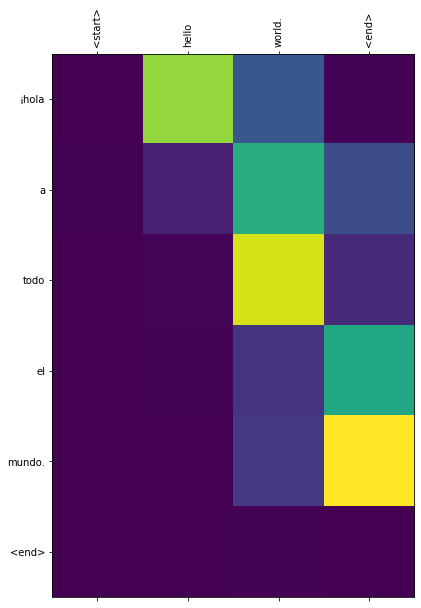

In [ ]:
sentence,trad,attention, inputs_ =translate("Hello World.")

Input : <start> all we need is love. <end>
predicted sentence :<start> lo que necesitamos es amor. <end>


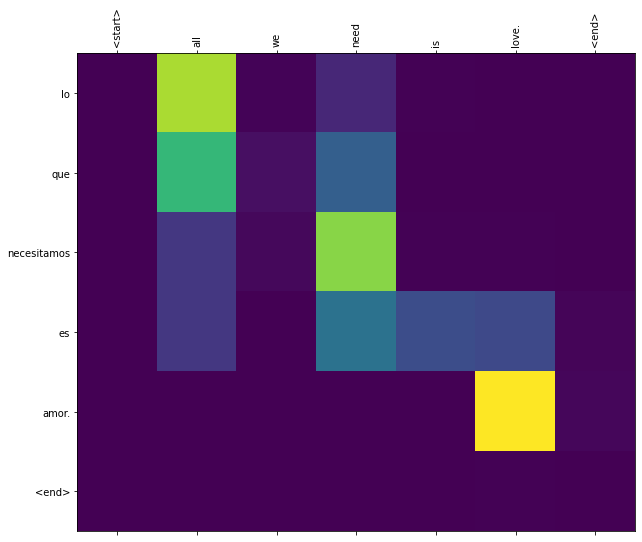

In [ ]:
sentence,trad,attention, inputs_ =translate("All we need is love.")

En nuestros dos ejemplos mostramos resultados de haber realizado la traducción en ambos observamos que la traducción no es mala por lo que podemos decir que los resultados son buenos al traducir de inglés a español.

### d) Una métrica para evaluar la calidad de la traducción es BLEU (Bilingual Evaluation Understudy, Papinoni et al., 2002). Realiza la evaluación de tu modelo mediante BLEU usando un conjunto de sentencias de prueba. Da tu opinión sobre la calidad de la traducción. Puedes apoyarte en https://blog.machinetranslation.io/compute-bleu-score/ para la implementación.

In [ ]:
def get_target_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +target_index_word[i]+' '
    return sentence 

def get_source_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +source_index_word[i]+' '
    return sentence  

In [ ]:
X_test.shape

(13474, 72)

In [ ]:
target_=[]
predict_=[]
for i in np.random.randint(1, 13473, size=1000):
    target_.append(get_target_sentence(y_test[i]))
    sent, attention = get_predicted_sentence(X_test[i].reshape(1,max_source_len))
    predict_.append(sent)

In [ ]:
!pip install sacrebleu

     |████████████████████████████████| 90 kB 5.3 MB/s 


In [ ]:
!pip install sacremoses

     |████████████████████████████████| 895 kB 7.1 MB/s 


In [ ]:
import sacrebleu
from sacremoses import MosesDetokenizer
md = MosesDetokenizer(lang='en')


# Open the test dataset human translation file and detokenize the references
refs = []

for line in target_: 
  line = line.strip().split() 
  line = md.detokenize(line) 
  refs.append(line)
    
print("Reference 1st sentence:", refs[0])

refs = [refs]  # Yes, it is a list of list(s) as required by sacreBLEU


# Open the translation file by the NMT model and detokenize the predictions
preds = []

for line in predict_: 
  line = line.strip().split() 
  line = md.detokenize(line) 
  preds.append(line)

print("MTed 1st sentence:", preds[0])    


# Calculate and print the BLEU score
bleu = sacrebleu.corpus_bleu(preds, refs)
print(bleu.score)

Reference 1st sentence: <start> se acabó todo. <end>
MTed 1st sentence: <start> todo está hecho. <end>
61.22086229545785


En la anterior linea encontramos los resultados de evaluar la calidad de la metrica, nos da un resultado bueno.

# Español - Ingles
Ahora lo que vamos a realizar es basicamente lo mismo que se hizo para el modelo inglés-español pero ahora buscamos un modelo de español a inglés.

In [ ]:
# convert to list for tokenizer
source_texts = df.Spanish.to_list() 
target_texts = df.English.to_list()

In [ ]:
def tokenize_sent(text):
  '''
  Take list on texts as input and 
  returns its tokenizer and enocded text
  '''
  tokenizer = Tokenizer(filters = '')
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)

# Tokenize source and target sentences
source_tokenizer, source_encoded= tokenize_sent(text= source_texts)
target_tokenizer, target_encoded= tokenize_sent(text= target_texts)

# diccionarios para el mapeo entre one-hot encodings y vocabulario
source_index_word = source_tokenizer.index_word
source_word_index= source_tokenizer.word_index
source_VOCAB_SIZE = len(source_tokenizer.word_counts)+1
target_index_word = target_tokenizer.index_word
target_word_index= target_tokenizer.word_index
target_VOCAB_SIZE=len(target_tokenizer.word_counts)+1

max_source_len = 0
for i in range(len(source_encoded)):
  if len(source_encoded[i]) > max_source_len:
    max_source_len= len(source_encoded[i])

max_target_len = 0
for i in range(len(target_encoded)):
  if len(source_encoded[i]) > max_target_len:
    max_target_len= len(target_encoded[i])

print('Source language')
print('Vocabulary size: ', source_VOCAB_SIZE, 'Max sequence length: ', max_source_len)
print('Target language')
print('Vocabulary size: ', target_VOCAB_SIZE, 'Max sequence length: ', max_target_len)

Source language
Vocabulary size:  44123 Max sequence length:  70
Target language
Vocabulary size:  24663 Max sequence length:  72


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

source_padded = pad_sequences(source_encoded, maxlen=max_source_len, padding='post')
target_padded = pad_sequences(target_encoded, maxlen=max_target_len, padding='post')
# converting to array for processing
source_padded= np.array(source_padded)
target_padded= np.array(target_padded)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(source_padded, target_padded, test_size=0.1, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121262, 70), (13474, 70), (121262, 72), (13474, 72))

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate, Dropout
from tensorflow.keras import Input, Model
#from BahdanauAttention import AttentionLayer
from keras.layers.recurrent import LSTMCell

def get_encoder(vocab_size, source_len):
    encoder_inputs = Input(shape=(source_len,)) 
    enc_emb = Embedding(vocab_size, 1024)(encoder_inputs)
    # Bidirectional lstm layer
    enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
    encoder_outputs_lstm1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)
    final_enc_h = Concatenate()([forw_state_h,back_state_h])
    final_enc_c = Concatenate()([forw_state_c,back_state_c])
    # concatenate encoder states
    encoder_states =[final_enc_h, final_enc_c]
    
    return encoder_inputs, encoder_outputs_lstm1, final_enc_h, final_enc_c

def get_decoder(vocab_size, encoder_states):
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(vocab_size, 1024) 
    dec_emb = dec_emb_layer(decoder_inputs)
    #LSTM using encoder_states as initial state
    decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    
    return(decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm)

def get_model(source_vocabsize, source_maxlen, target_vocabsize):
    # encoder
    encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c = get_encoder(source_vocabsize, source_maxlen)
    # concatenate encoder states
    encoder_states =[final_enc_h, final_enc_c]
    # decoder
    decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm = get_decoder(target_vocabsize, encoder_states)
    #Attention Layer
    attention_layer = AttentionLayer()
    attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])
    # Concat attention output and decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])
    #Dense layer
    decoder_dense = Dense(target_vocabsize, activation='softmax')
    decoder_outputs = decoder_dense(decoder_concat_input)
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
    
    return model, encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, \
            decoder_inputs, decoder_dense, decoder_lstm, attention_layer

def get_inference_model(encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, \
                        decoder_inputs, decoder_dense, decoder_lstm, attention_layer):
    encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])
    decoder_state_h = Input(shape=(512,))
    decoder_state_c = Input(shape=(512,))
    decoder_hidden_state_input = Input(shape=(max_source_len,512))
    dec_states = [decoder_state_h, decoder_state_c]
    dec_emb2 = dec_emb_layer(decoder_inputs)
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

    # Attention inference
    attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
    decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

    dec_states2= [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

    decoder_model= Model(
                        [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                         [decoder_outputs2]+ dec_states2 + [attention_weights_inf] + [attention_result_inf])
    
    return encoder_model, decoder_model

In [ ]:
model, encoder_inputs, encoder_outputs1, final_enc_h, final_enc_c, dec_emb_layer, decoder_inputs, \
decoder_dense, decoder_lstm, attention_layer = get_model(source_VOCAB_SIZE, max_source_len, target_VOCAB_SIZE)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 70, 1024)     45181952    ['input_9[0][0]']                
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 70, 512),   2623488     ['embedding_2[0][0]']            
 )                               (None, 256),                                               

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = "weights-improvement-{loss:.4f}-bigger.hdf5" 

checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=False,
    save_frec="epoch"        
)  
#checkpoint = ModelCheckpoint("model3/", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
callbacks_list = [checkpoint, early_stopping]

In [ ]:
# Training
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# Testing
encoder_input_test = X_test
decoder_input_test = y_test[:,:-1]
decoder_target_test=  y_test[:,1:]

In [ ]:
EPOCHS= 10
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/10
948/948 [==============================] - 603s 632ms/step - loss: 0.5527 - accuracy: 0.9244 - val_loss: 0.3800 - val_accuracy: 0.9397
Epoch 2/10
948/948 [==============================] - 597s 630ms/step - loss: 0.2877 - accuracy: 0.9526 - val_loss: 0.2336 - val_accuracy: 0.9614
Epoch 3/10
948/948 [==============================] - 597s 630ms/step - loss: 0.1688 - accuracy: 0.9688 - val_loss: 0.1814 - val_accuracy: 0.9688
Epoch 4/10
948/948 [==============================] - 598s 630ms/step - loss: 0.1069 - accuracy: 0.9773 - val_loss: 0.1624 - val_accuracy: 0.9719
Epoch 5/10
948/948 [==============================] - 598s 631ms/step - loss: 0.0705 - accuracy: 0.9835 - val_loss: 0.1580 - val_accuracy: 0.9729
Epoch 6/10
948/948 [==============================] - 598s 631ms/step - loss: 0.0496 - accuracy: 0.9877 - val_loss: 0.1578 - val_accuracy: 0.9734
Epoch 7/10
948/948 [==============================] - 598s 631ms/step - loss: 0.0373 - accuracy: 0.9904 - val_loss: 0.1590 -

In [ ]:
encoder_model, decoder_model = \
                                get_inference_model(encoder_inputs, encoder_outputs1, final_enc_h, \
                                final_enc_c, dec_emb_layer, decoder_inputs, decoder_dense, \
                               decoder_lstm, attention_layer)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
    # attention weights for each token in output sequence
    attention_weights = np.empty(shape=[0, max_source_len])
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_word_index['<start>']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = '<start>'
    
    while not stop_condition:
        output_tokens, h, c, attention_w, attention_c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        #print(attention_w.shape)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
          break
        else:
            # convert max index number to spanish word
            sampled_char = target_index_word[sampled_token_index]

        if (sampled_char!='<end>'):
            # aapend it ti decoded sent
            decoded_sentence += ' '+sampled_char
            attention_weights = np.append(attention_weights,[attention_w.reshape(-1,)],axis=0)
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '<end>' or len(decoded_sentence.split()) >= max_source_len):
            attention_weights = np.append(attention_weights,[attention_w.reshape(-1,)],axis=0)
            decoded_sentence += ' '+'<end>'
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence, attention_weights

In [ ]:
def preprocess_sentence(sentence):
    
    num_digits= str.maketrans('','', digits)
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub(" ", " ", sentence)
    #sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    #sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  '<start> ' + sentence + '\t<end> '
    sentence = " ".join(sentence.split())
    return sentence

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(1,1,1)
    ax.matshow(attention)
    fontdict={'fontsize':10}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence[1::], fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence = preprocess_sentence(sentence)
  
  #convert the sentence to index based on word2index dictionary
  inputs= [source_word_index[i] for i in sentence.split(' ')]
  # pad the sequence 
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_len, padding='post')

  #conver to tensors
  inputs = tf.convert_to_tensor(inputs)
  trad, attention =get_predicted_sentence(inputs)
  print('Input : %s' % (sentence))
  print('predicted sentence :{}'.format(trad))

  #attention_plot = np.zeros((max_target_len, max_source_len))
  
  attention_plot= attention[:len(trad.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), trad.split(' '))

  return(sentence,trad,attention,inputs )


Input : <start> hola mundo. <end>
predicted sentence :<start> hi, guys. <end>


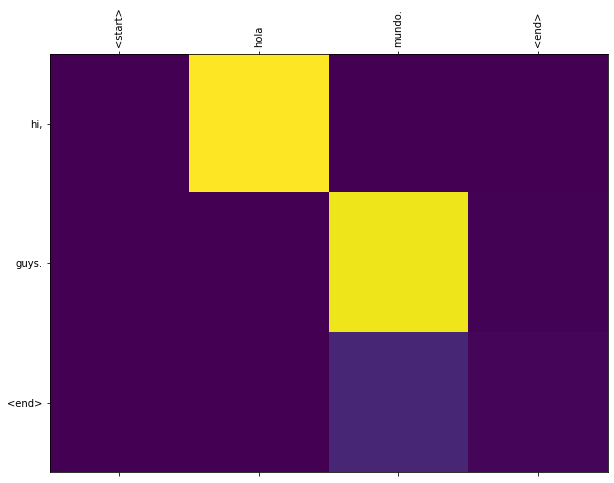

In [ ]:
sentence,trad,attention, inputs_ =translate("Hola mundo.")

Input : <start> somos los martillos y las ruedas <end>
predicted sentence :<start> we're the subject and the guys. <end>


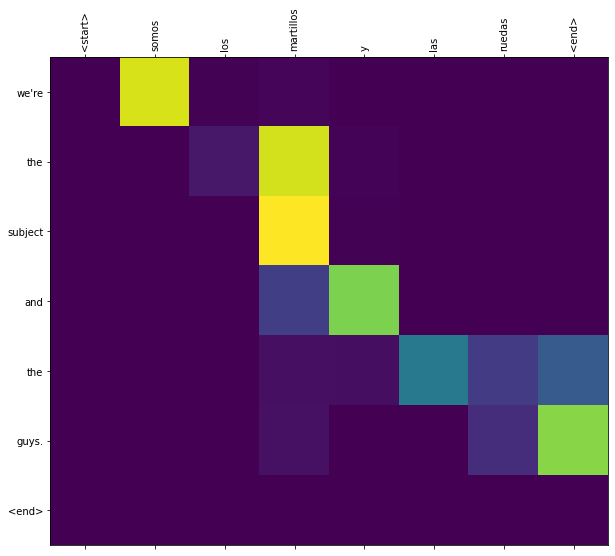

In [ ]:
sentence,trad,attention, inputs_ =translate("Somos los martillos y las ruedas.")

Input : <start> hoy viernes me di cuenta que la noche no es tan larga. <end>
predicted sentence :<start> today i was today when i isn't so long in the long time. <end>


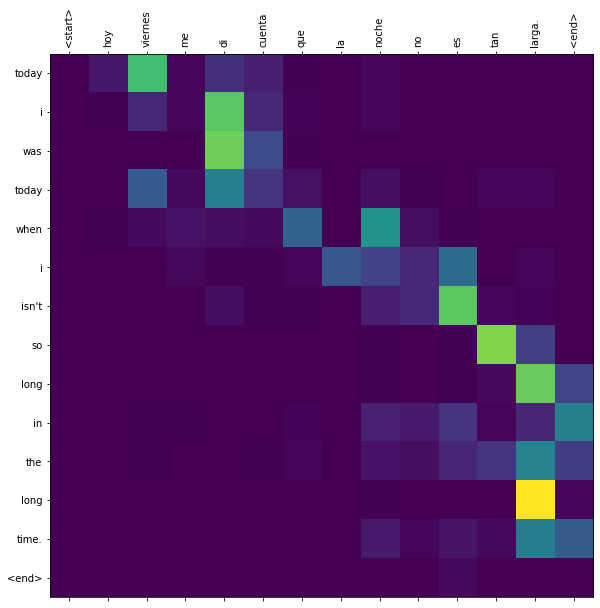

In [ ]:
sentence,trad,attention, inputs_ =translate("Hoy viernes me di cuenta que la noche no es tan larga.")

En este caso dimos tres ejemplos, en ellos sobservamos que los resultados no fueron tan malos, en algunos de ellos cambiaron varias palabras por otras que se pueden considerar como equivocadas. 

e) El modelo NMT que usaste utiliza una capa de atención basado en Bahdanau et. al., (2015), pero otras opciones son las llamadas "Atención Global" y "Atención Local" propuesta por Luong et. al., (2015). Describe brevemente las diferencias entre éstos enfoques de atención, y cuál crees que es mejor para la tarea de traducción automática.

OPCIONAL: incluye los modelos de atención de Luong y verifica su desempeño en tu modelo NMT.

##### Atención Global

La atención global es considerar todos los estados ocultos de codificador al derivar ek vector de contexto $c_t$, en este modelo, un vector llamado de longitud variables, cuyo tamaño es igual al número de pasos de tiempo en el lado de la fuente, se deriva comprando el estado oculto de destino actual $h_t$ con cada estado oculto de origen. En cada pas de tiempo  $t$, el modelo infiere un vector de peso de alineación de longitud variable $a_t$ basado en el estado actual $h_t$ y todos los estados fuente.

##### Atención Local

La atención local surgio como una alternativa para atender algunas deficiencias de la atención global. En ella se tiene que prestar atención a todas las palabras en el lado del corpus fuente para cada palabra de destino, pero es poco practico y efectivo traducir sentencias más largas como párrafos o documentos. Por lo que se propusó un mecanismo de tención local que elige centrarse sólo en un pequeño subconjunto de las posisiciones de origen por palabra de destino.

### f) OPCIONAL. Un problema en particular con el inglés, son las contracciones. Por ejemplo, en el modelo que yo entrené tengo éstos resultados.

Texto:  `<start> i'm young and a good guy <end>`

Traducción:  `<start> soy joven y un buen tipo. <end>`

Texto:  `<start> i am young and a good guy <end>`

Traducción:  `<start> soy joven como un buen tipo. <end>`

Una forma de resolverlo es incluir ambos tipos de versiones (contracción y completa) relacionadas con su respectiva traducción en el corpus de entrenamiento. Hay varias formas de hacerlo. Por ejemplo, en el código que se muestra en la siguiente celda se hace realiza la expansión el texto basado en un diccionario de contracciones de inglés (contraction_expansion.txt). Implementa ésta idea para aumentar el corpus de entrenamiento y verifica si el desempeño del traductor  mejora.

In [ ]:
with open("contraction_expansion.txt", 'rb') as fp:
    contractions= pickle.load(fp)

def expand_eng_text(text):
    if type(text) is str:
        for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)
        return text
    else:
        return text

# ejemplo:
txt = "i'm don't he'll you'll"
print(expand_contras(txt))
>> 'i am do not he will you will'

SyntaxError: ignored

In [ ]:
# TU CÓDIGO AQUI